In [19]:
%matplotlib inline

This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

The core model is an GRU.

# todos:
* dropout
* L1/L2 regularization
* validation and AUC

In [44]:
from __future__ import print_function, division
from io import open
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [45]:
use_cuda


True

In [46]:
# prepare data: load the input file containing list of list, and corresponding label file
# and output the merged list of pairs
import sys, random
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle

# set random seed
random.seed( 3 )

seqFile = 'Data/h143.visits'
labelFile = 'Data/h143.labels'
set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')

x_flat =[]
for patient in set_x:
    x_flat.append([each for visit in patient for each in visit])  #modified, put all visits sequentially into a single list for each patients

labeled_ehr_seq_list = [(set_y[i],x_flat[i]) for i in range(len(set_y))] # merge the two lists

In [47]:
labeled_ehr_seq_list[1]
# [float(v) for v in c]

(0,
 [5814,
  714,
  6636,
  109,
  84,
  85,
  714,
  109,
  84,
  85,
  150,
  714,
  673,
  109,
  84,
  85,
  714,
  109,
  84,
  85,
  5814,
  714,
  109,
  84,
  85,
  5814,
  714,
  778,
  109,
  84,
  85,
  714,
  68,
  109,
  84,
  85,
  5814,
  714,
  109,
  84,
  85,
  714,
  68,
  109,
  84,
  85,
  714,
  778,
  109,
  84,
  85,
  714,
  778,
  231,
  84,
  85,
  714,
  231,
  84,
  85,
  714,
  231,
  84,
  85,
  714,
  231,
  84,
  85])

In [48]:
#Logistic Regression: 
class EHR_LR(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1): #hidden_size -> out_size in Logistic Regression 
        super(EHR_LR, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size,hidden_size)
        self.out = nn.Linear(self.hidden_size,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input,hidden):
        embedded = self.embedding(input).view(-1, self.hidden_size) #modified, instead of (-1,1, self.hidden_size) => use (-1,self.hidden_size
        embedded = torch.sum(embedded, dim=0).view(1,-1) #modified,instead of (1,1,-1) => use .view(1,-1)
        #output = embedded
        #for i in range(self.n_layers):
            #output, hidden = self.gru(output, hidden)
            
        output = self.sigmoid(self.out(embedded))
        hidden = self.sigmoid(self.out(embedded)) #modified,hidden == out for Logistic Regression 
        return output,hidden 

    def initHidden(self):
        result = Variable(torch.zeros(1,self.hidden_size)) #modified, instead of (1,1,self.hidden_size) => use (1,self.hidden_size)
        if use_cuda:
            return result.cuda()
        else:
            return result

In [49]:
# training one sample
def train(label_tensor, ehr_seq_tensor, criterion, optimizer):
    hidden = ehr_lr.initHidden()  #modified the class name in this section

    ehr_lr.zero_grad()

    for i in range(len(ehr_seq_tensor)):
        output, hidden = ehr_lr(ehr_seq_tensor[i],hidden)

    loss = criterion(output, label_tensor)
    loss.backward()

    optimizer.step()
   
    return output, loss.data[0]


In [50]:
def variableFromEHRSeq(ehr_seq):
    # ehr_seq is a list   
    result = []
    if use_cuda:
        #for i in range(len(ehr_seq)):
        result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq])).cuda() ) #modified, just need a simple list comprehension 
    # if use_cuda:
    #     return result.cuda()
    else:
        #for i in range(len(ehr_seq)):
        result.append( Variable(torch.LongTensor([int(v) for v in ehr_seq])) )

    return result

In [51]:
# training all samples in random order
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

input_size = 20000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [52]:
start = time.time()
ehr_lr = EHR_LR(input_size, hidden_size = 2) #modified, class names 
if use_cuda:
    ehr_lr = ehr_lr.cuda()
learning_rate = 0.001
optimizer = optim.SGD(ehr_lr.parameters(), lr=learning_rate)

for iter in range(1, n_iters + 1):
    label, ehr_seq = random.choice(labeled_ehr_seq_list)
    label_tensor = Variable(torch.FloatTensor([[float(label)]]))
    if use_cuda:
        label_tensor = label_tensor.cuda() 
    ehr_seq_tensor = variableFromEHRSeq(ehr_seq)
    
    output, loss = train(label_tensor, ehr_seq_tensor, criterion = nn.BCELoss(), optimizer = optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 0.0529 
10000 10% (0m 12s) 0.1868 
15000 15% (0m 18s) 0.1734 
20000 20% (0m 24s) 0.1219 
25000 25% (0m 30s) 0.0380 
30000 30% (0m 36s) 0.1948 
35000 35% (0m 42s) 0.1204 
40000 40% (0m 48s) 0.1122 
45000 45% (0m 54s) 0.1078 
50000 50% (0m 59s) 0.1124 
55000 55% (1m 5s) 0.0250 
60000 60% (1m 11s) 0.0269 
65000 65% (1m 17s) 0.1084 
70000 70% (1m 23s) 0.1181 
75000 75% (1m 29s) 0.2151 
80000 80% (1m 36s) 0.0624 
85000 85% (1m 42s) 0.1178 
90000 90% (1m 48s) 0.0358 
95000 95% (1m 54s) 0.0443 
100000 100% (2m 0s) 0.1410 


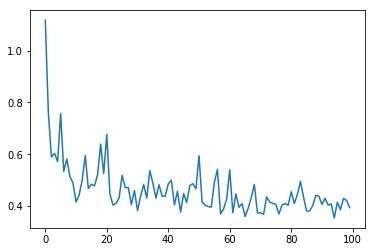

In [53]:
# plotting and diagnose
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
showPlot(all_losses)

In [54]:
# validation/test


In [55]:
all_losses

[1.1178880953002714,
 0.759988612756414,
 0.5892062380706398,
 0.6032635505719816,
 0.571615174145913,
 0.7571071348771498,
 0.5337220434978612,
 0.5816163071194536,
 0.5139647589311962,
 0.4882766389838671,
 0.4149907847108907,
 0.44213399106162987,
 0.4998993152814075,
 0.5945665030215144,
 0.4668747361704627,
 0.48424400789331234,
 0.477227290223302,
 0.5200678698640061,
 0.6388221309924312,
 0.525030606729481,
 0.6766642074553493,
 0.44738992886623785,
 0.4034963713213364,
 0.4097970876342091,
 0.43065899013573605,
 0.518133793542454,
 0.47099769820311915,
 0.4707769335181331,
 0.4050755238192585,
 0.4591834164657194,
 0.38194736802286205,
 0.437829800622309,
 0.48266408973794883,
 0.43056158725719434,
 0.5368324585027858,
 0.4875680397473188,
 0.42993124781552433,
 0.4817434499601059,
 0.4375720585061538,
 0.4377485873580963,
 0.4850336117939281,
 0.49986198692933703,
 0.40389936284431316,
 0.4567390110261622,
 0.37610699955606103,
 0.44787630684731994,
 0.41308105378923937,
 0.47